In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from file_manager import FileManager
fm = FileManager()

In [2]:
# Pass in player dataframe
def overview(df: pd.DataFrame):
    infocols: list[str,...] = ['date', 'name', 'team', 'opp', 'starter']
    statcols: list[str,...] = [col for col in df.columns if col not in infocols]

    last10: list[str,...] = list((df
                                  .sort_values('date', ascending=False)
                                  ['date']
                                 ))[:10]
    
    last5: list[str,...] = last10[:5]
    
    # overview
    ov: dict[str,str|int|float] = {
        'name': df['name'].drop_duplicates().item(),
        'team(s)': ','.join(df['team'].drop_duplicates()),
        'played': len(df),
        'started': len(df.loc[df['starter']==1])
    }
    
    distro: pd.Series = df['fpts'].describe().round(1)
    
    ov: dict[str, str|int|float] = {
        **ov,
        **{'ceiling': distro['75%'],'floor': distro['25%']},
        **{f'med-{stat}': np.median(df[stat]).round(2) for stat in statcols},
        **{
            f'l10-median-{stat}': np.median(df.loc[df['date'].isin(last10),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        },
        **{
            f'l5-median-{stat}': np.median(df.loc[df['date'].isin(last5),stat]) 
            for stat in ('fpts', 'fppm', 'mp')
        }
    }
    
    return pd.Series(ov)

In [3]:
# Return graph of player outcomes
def view_player(name: str, **kwargs):
    
    columns: list[str,...] = [
        'date',
        'name',
        'team',
        'opp',
        'fpts',
        'mp',
        'fppm',
        'usg',
        'pts',
        'ast',
        'trb',
        'starter'
    ]
    
    stats: list[str,...] = sum([
        columns,
        kwargs.get('stats', [])
    ], [])
    
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                 ])
                        [stats]
                       )
    
    ov: pd.Series = overview(df)
    bins_: int = int(ov['played']) // 1
    print(ov)
    
    plot: str = kwargs.get('plot', 'histogram')
    plotkwargs = {kw:arg for kw,arg in kwargs.items() if kw not in ('stats','target', 'starter')}
    
    plotkwargs = {
        **plotkwargs,
        **{'figsize': plotkwargs.get('figsize',(15,10)), 'bins': plotkwargs.get('bins', bins_)}
    }
    
    target: str = kwargs.get('target', 'fpts')
    
    
    if plot in ('hist', 'histogram'):
        return (df
                .plot
                .hist(
                    column=[target],
                    # Nondefault args for hist
                    # bins=plotkwargs.get('bins', 7),
                    # figsize=figsize,
                    **plotkwargs
                )
               )
    
    if plot in ('box', 'boxplot'):
        return (df
                .plot
                .box(column=[target],figsize=plotkwargs['figsize'])
               )
    
    return None

name               Anthony Davis
team(s)                      LAL
played                        36
started                       36
ceiling                     61.4
floor                       40.3
med-fpts                   57.15
med-mp                     35.22
med-fppm                    1.63
med-usg                     0.28
med-pts                     26.0
med-ast                      2.0
med-trb                     13.5
l10-median-fpts             54.0
l10-median-fppm         1.639357
l10-median-mp          34.766667
l5-median-fpts              56.5
l5-median-fppm          1.711069
l5-median-mp           31.066667
dtype: object


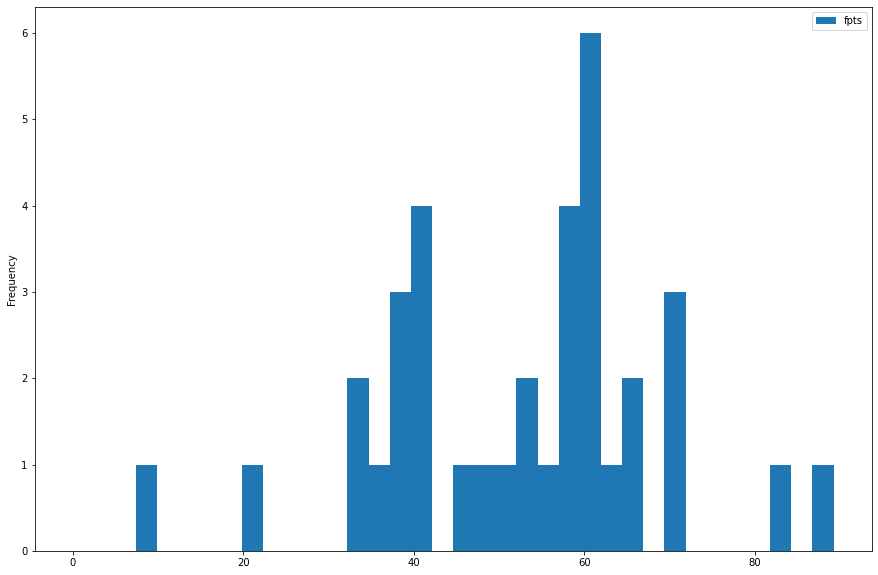

In [4]:
view_player(
    'Anthony Davis',
    starter=True,
    # plot='box',
    # bins=46,
);

In [5]:
def boom_bust(name: str, salary: int, **kwargs) -> tuple[float, float]:
    starter_: tuple[int,...] = (0,1) if kwargs.get('starter') is None else (int(kwargs['starter']),)
    df: pd.DataFrame = (fm
                        .load_clean_data()
                        .pipe(lambda df_: df_.loc[(df_['name'] == name)
                                                  & df_['starter'].isin(starter_)
                                                 ])
                        [['name', 'fpts']]
                        .set_index('name')
                       )
    
    five_x: float = 5 * (salary / 1000)
    total: int = len(df)
    
    boom: int = len(df.loc[df['fpts']>=five_x+10])
    bust: int = len(df.loc[df['fpts']<five_x])
    
    
    return (pd
            .Series({'boom': 100*(boom/total), 'bust': 100*(bust/total)})
            .round(2)
            # .plot
            # .barh(figsize=(10,5))
           )
    
    
    # return tuple([ 100*(val/total) for val in (boom, bust) ])
    
    # return df

In [35]:
boom_bust('Joel Embiid', 11800, starter=True)

boom    14.58
bust    66.67
dtype: float64

In [7]:
boom_bust('Kawhi Leonard', 10000, starter=True)

boom     8.57
bust    74.29
dtype: float64

In [31]:
boom_bust('Luka Doncic', 12000, starter=True)

boom    16.98
bust    56.60
dtype: float64

In [24]:
boom_bust('Paul George', 9000, starter=True)

boom    14.89
bust    74.47
dtype: float64

In [26]:
boom_bust('Scottie Barnes', 7800, starter=True)

boom     8.47
bust    66.10
dtype: float64

In [27]:
boom_bust('Kyle Kuzma', 7700, starter=True)

boom    12.50
bust    64.29
dtype: float64

In [28]:
boom_bust('Pascal Siakam', 9300, starter=True)

boom    18.87
bust    60.38
dtype: float64

In [32]:
boom_bust('Donte DiVincenzo', 6500, starter=True)

boom     5.88
bust    70.59
dtype: float64

In [34]:
boom_bust('Tobias Harris', 6000, starter=True)

boom    14.04
bust    54.39
dtype: float64

boom_bust('Kristaps Porzingis', 9100, starter=True)

In [21]:
boom_bust('Andrew Nembhard', 4300, starter=True)

boom    11.36
bust    63.64
dtype: float64

In [20]:
boom_bust('TJ McConnell', 4700, starter=True)

boom    50.00
bust    33.33
dtype: float64

In [14]:
boom_bust('Buddy Hield', 5900, starter=True)

boom    19.05
bust    47.62
dtype: float64

In [13]:
boom_bust('Myles Turner', 8600, starter=True)

boom     9.43
bust    67.92
dtype: float64

In [12]:
boom_bust('Aaron Nesmith', 5100, starter=True)

boom     9.09
bust    72.73
dtype: float64

In [11]:
boom_bust('Bennedict Mathurin', 5200, starter=False)

boom    12.28
bust    50.88
dtype: float64

In [37]:
boom_bust('Josh Green', 4500, starter=False)

boom     3.03
bust    78.79
dtype: float64

In [36]:
boom_bust('Deni Avdija', 5400, starter=False)

boom    12.0
bust    56.0
dtype: float64

In [16]:
boom_bust('Zach Collins', 6800, starter=True)

boom     7.14
bust    71.43
dtype: float64